In [36]:
import cholesky_kalman_impl as chol
import jax
import jax.numpy as jnp
import IWPprior


def chol_marginal_and_reverse_deterministic_conditional(
    m_in, Ch_in, A_cond, b_cond
) -> chol.LikelihoodMarginalParams:
    R = jnp.linalg.qr((A_cond @ Ch_in.T).T, mode="r")
    Ch_out = R.T

    A_rev = jnp.linalg.solve(
        R, jnp.linalg.solve(R.T, (Ch_in @ Ch_in.T @ A_cond.T).T).T
    ).T
    # R_inv = jnp.linalg.inv(R)
    # A_rev = (Ch_in @ Ch_in.T @ A_cond.T) @ R_inv @ R_inv.T

    Ch_rev = Ch_in - A_rev @ A_cond @ Ch_in
    m_out = A_cond @ m_in + b_cond
    b_rev = m_in - A_rev @ m_out

    return chol.LikelihoodMarginalParams(A_rev, b_rev, Ch_rev, m_out, Ch_out)

## filter and smooth, jit'able - full JAX

In [37]:
import matplotlib.pyplot as plt


time_step = 0.1
n_steps = 100

collocation_points = jnp.arange(0, n_steps) * time_step


derivatives = 1

k = 1

A, Q = IWPprior.get_IWP_Prior_SDE_coefficients(size=1, derivatives=derivatives)
Q *= k
# Q.at[-1, -1].set(-1.0)

A, Q = IWPprior.fast_get_discrete_system_coeffs(A, Q, time_step)
b = jnp.zeros(derivatives + 1)
Q = 0.5 * (Q + Q.T)

H = jnp.array([[0] * derivatives + [1.0]])
# H = jnp.array([[-5.0, -0.1, -1.0]])
Ch_R = jnp.array([[0.05]]) * k
b_cond_obs = jnp.ones(1) * (0)


prior_m = jnp.array([0.0] * derivatives + [1.0])
prior_Ch = jnp.eye((derivatives + 1)) * 0.001 * k
# prior_Ch = jnp.linalg.cholesky(prior_Ch)

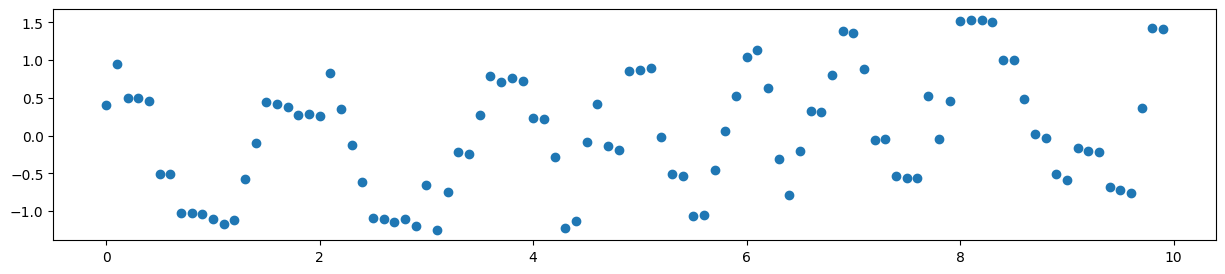

In [38]:
random_acc = (
    jnp.cumsum(
        jax.random.normal(
            jax.random.PRNGKey(0),
            (len(collocation_points),),
        ),
        axis=0,
    )
    * 0.5
)

bins = 0.5

observations = (
    bins * jnp.round((1 / bins) * jnp.cos(collocation_points * 4 + random_acc))
).reshape(-1, 1)

observations += jnp.cumsum(
    jax.random.normal(jax.random.key(0), observations.shape) * 0.05, axis=0
)

fig, ax = plt.subplots(1, figsize=(15, 3))
ax.scatter(collocation_points, observations)

In [39]:
def plot_state(states, ax, samples=None):
    if isinstance(states, list):
        means = jnp.array([x.mean for x in states])
        stds = jnp.sqrt(
            jnp.array([jnp.diag((x.chol_cov @ x.chol_cov.T)) for x in states])
        )
    elif isinstance(states, tuple):
        means, chol_covs = states
        covariances = jnp.einsum("ijk,ilk->ijl", chol_covs, chol_covs)
        stds = jnp.sqrt(jnp.diagonal(covariances, axis1=1, axis2=2))

    colormap = plt.cm.get_cmap("tab20")

    for i in range(means.shape[1]):
        # plot 3 layers of stds
        for j in range(1, 3 + 1):
            ax.fill_between(
                collocation_points,
                means[:, i] - j * stds[:, i],
                means[:, i] + j * stds[:, i],
                alpha=0.1,
                color=colormap((i * 3) % 20),
            )
        # plot the process mean
        ax.plot(
            collocation_points,
            means[:, i],
            label=rf"$Y^{({i})}$",
            color=colormap((i * 3) % 20),
        )
        # plot the samples
        if samples is not None:
            for sample in samples:
                ax.plot(
                    collocation_points,
                    sample[:, i],
                    linewidth=0.5,
                    color=colormap((i * 3) % 20),
                    alpha=0.8,
                )
    ax.scatter(
        collocation_points,
        observations,
        label="velocity observations",
        s=4,
        color=colormap(((i * 3) + 1) % 20),
    )
    ax.legend()


/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_57771/3905347482.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab20")


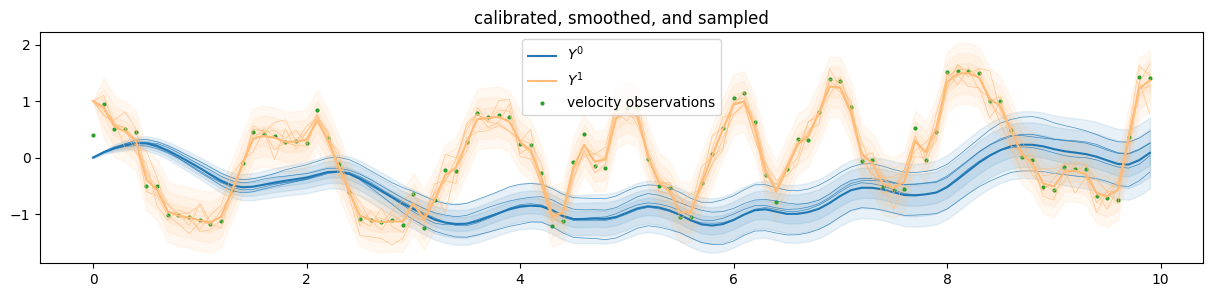

In [40]:
filtered, reverse_parameters = chol.jax_batch_filter(
    prior_mean=prior_m,
    prior_cholvariance=prior_Ch,
    A_cond_obs=H,
    b_cond_obs=jnp.zeros(1),
    Ch_cond_obs=Ch_R,
    A_cond_state=A,
    b_cond_state=b,
    Ch_cond_state=Q,
    # update_indicator=jnp.ones(n_steps),
    observations=observations,
)

last_filtered = chol.CholGauss(filtered.mean[-1], filtered.chol_cov[-1])
smooth_means, smooth_chol_covs, samples = chol.jax_batch_smooth_and_sample(
    last_filtered,
    reverse_parameters,
    n_samples=5,
)

fig, ax = plt.subplots(1, figsize=(15, 3))

plot_state(((smooth_means), (smooth_chol_covs)), ax, samples=samples.transpose(1, 0, 2))

ax.set_title("calibrated, smoothed, and sampled");